# Self made RP3-beta

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
class RP3Beta():
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui=train_ui
        self.train_iu=train_ui.transpose()
        
        self.alpha = alpha
        self.beta = beta
        
        # Define Pui 
        Pui=sparse.csr_matrix(self.train_ui/self.train_ui.sum(axis=1))
        
        # Define Piu
        to_divide=np.vectorize(lambda x: x if x>0 else 1)(self.train_iu.sum(axis=1)) # to avoid dividing by zero
        Piu=sparse.csr_matrix(self.train_iu/to_divide)
        item_orders=(self.train_ui>0).sum(axis=0)
        
        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3=Pui*Piu*Pui
        
        P3/=np.power(np.vectorize(lambda x: x if x>0 else 1)(item_orders), self.beta)
        
        self.estimations=np.array(P3)
    
    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [4]:
top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_P3_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', index=False, header=False)

In [5]:
import evaluation_measures as ev
estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 9220.23it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.875928           1.0       0.077201  3.875892  0.974947

# Let's check hiperparameters

##### Alpha

In [6]:
from tqdm import tqdm
result=[]
for alpha in tqdm([round(i,1) for i in np.arange(0.2,1.6001,0.2)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/8 [00:00<?, ?it/s]
943it [00:00, 9951.34it/s]
 12%|█▎        | 1/8 [00:08<01:00,  8.59s/it]
0it [00:00, ?it/s]
943it [00:00, 9002.19it/s]
 25%|██▌       | 2/8 [00:17<00:51,  8.55s/it]
943it [00:00, 9650.83it/s]
 38%|███▊      | 3/8 [00:25<00:42,  8.59s/it]
943it [00:00, 9645.16it/s]
 50%|█████     | 4/8 [00:34<00:34,  8.56s/it]
943it [00:00, 9747.61it/s]
 62%|██████▎   | 5/8 [00:42<00:25,  8.56s/it]
0it [00:00, ?it/s]
943it [00:00, 8754.83it/s]
 75%|███████▌  | 6/8 [00:51<00:17,  8.55s/it]
943it [00:00, 9849.34it/s]
 88%|████████▊ | 7/8 [01:00<00:08,  8.60s/it]
943it [00:00, 9550.72it/s]
100%|██████████| 8/8 [01:08<00:00,  8.57s/it]


Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.850477      1.000000       0.060606  3.669627  0.979636  
0  0.854719      1.000000       0.064214  3.726996  0.978426  
0  0.870626      1.000000       0.065657  3.785282  0.977090  
0  0.874867      1.000000       0.070707  3.832415  0.975998  
0  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.883351      1.000000       0.085859  3.910718  0.974073  
0  0.871686      1.000000       0.107504  3.961915  0.972674  
0  0.868505      0.999576       0.156566  4.060156  0.969203

In [7]:
metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [8]:
from tqdm import tqdm
result=[]
for beta in tqdm([round(i,1) for i in np.arange(0,1,0.1)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Beta", beta)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 8518.16it/s]
 10%|█         | 1/10 [00:08<01:20,  8.89s/it]
943it [00:00, 9548.16it/s]
 20%|██        | 2/10 [00:18<01:11,  8.98s/it]
0it [00:00, ?it/s]
943it [00:00, 8836.58it/s]
 30%|███       | 3/10 [00:26<01:02,  8.87s/it]
0it [00:00, ?it/s]
943it [00:00, 8920.03it/s]
 40%|████      | 4/10 [00:35<00:52,  8.80s/it]
0it [00:00, ?it/s]
943it [00:00, 9269.76it/s]
 50%|█████     | 5/10 [00:44<00:44,  8.87s/it]
0it [00:00, ?it/s]
943it [00:00, 8958.45it/s]
 60%|██████    | 6/10 [00:53<00:35,  8.80s/it]
0it [00:00, ?it/s]
943it [00:00, 8674.45it/s]
 70%|███████   | 7/10 [01:01<00:26,  8.79s/it]
943it [00:00, 9648.17it/s]
 80%|████████  | 8/10 [01:10<00:17,  8.77s/it]
943it [00:00, 9457.86it/s]
 90%|█████████ | 9/10 [01:19<00:08,  8.73s/it]
0it [00:00, ?it/s]
943it [00:00, 8711.65it/s]
100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.884411      1.000000       0.085137  3.957416  0.972784  
0  0.886532      1.000000       0.094517  4.053212  0.969980  
0  0.888653      1.000000       0.105339  4.147779  0.966948  
0  0.895016      0.999894       0.132035  4.259682  0.962989  
0  0.903499      0.999046       0.168831  4.411281  0.956648  
0  0.897137      0.996394       0.212843  4.621938  0.945932  
0  0.868505      0.983033       0.256854  4.898568  0.928065  
0  0.803818      0.936373       0.341270  5.257397  0.895882  
0  0.580064      0.800106       0.415584  5.563910  0.857396

In [9]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Beta'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Beta', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

user  rating                                          title  \
28480   774       5                        Right Stuff, The (1983)   
50423   774       5                     Conan the Barbarian (1981)   
18188   774       5                     Clockwork Orange, A (1971)   
22286   774       5                           Groundhog Day (1993)   
23943   774       5                          Apocalypse Now (1979)   
51726   774       5  Star Trek VI: The Undiscovered Country (1991)   
16714   774       5              Man Who Would Be King, The (1975)   
42312   774       5       Treasure of the Sierra Madre, The (1948)   
37594   774       4              Nightmare on Elm Street, A (1984)   
16066   774       4                          Godfather, The (1972)   
62624   774       4                              Highlander (1986)   
3611    774       4                                  Aliens (1986)   
57765   774       4                     Killing Fields, The (1984)   
54287   774       4                            12 Angry Men (1957)   
47568   774       4                                   Alien (1979)   

                                 genres  
28480                             Drama  
50423                 Action, Adventure  
18188                            Sci-Fi  
22286                   Comedy, Romance  
23943                        Drama, War  
51726         Action, Adventure, Sci-Fi  
16714                         Adventure  
42312                         Adventure  
37594                            Horror  
16066              Action, Crime, Drama  
62624                 Action, Adventure  
3611      Action, Sci-Fi, Thriller, War  
57765                        Drama, War  
54287                             Drama  
47568  Action, Horror, Sci-Fi, Thriller

user  rec_nb                                      title  \
900   774.0       1           Silence of the Lambs, The (1991)   
3335  774.0       2                           Toy Story (1995)   
7822  774.0       3                 Princess Bride, The (1987)   
4301  774.0       4                      Twelve Monkeys (1995)   
8426  774.0       5  Indiana Jones and the Last Crusade (1989)   
8752  774.0       6                     Terminator, The (1984)   
2075  774.0       7                  Back to the Future (1985)   
8681  774.0       8                        Forrest Gump (1994)   
7507  774.0       9            Star Trek: First Contact (1996)   
7942  774.0      10                             Amadeus (1984)   

                                  genres  
900                      Drama, Thriller  
3335       Animation, Children's, Comedy  
7822  Action, Adventure, Comedy, Romance  
4301                       Drama, Sci-Fi  
8426                   Action, Adventure  
8752            Action, Sci-Fi, Thriller  
2075                      Comedy, Sci-Fi  
8681                Comedy, Romance, War  
7507           Action, Adventure, Sci-Fi  
7942                      Drama, Mystery

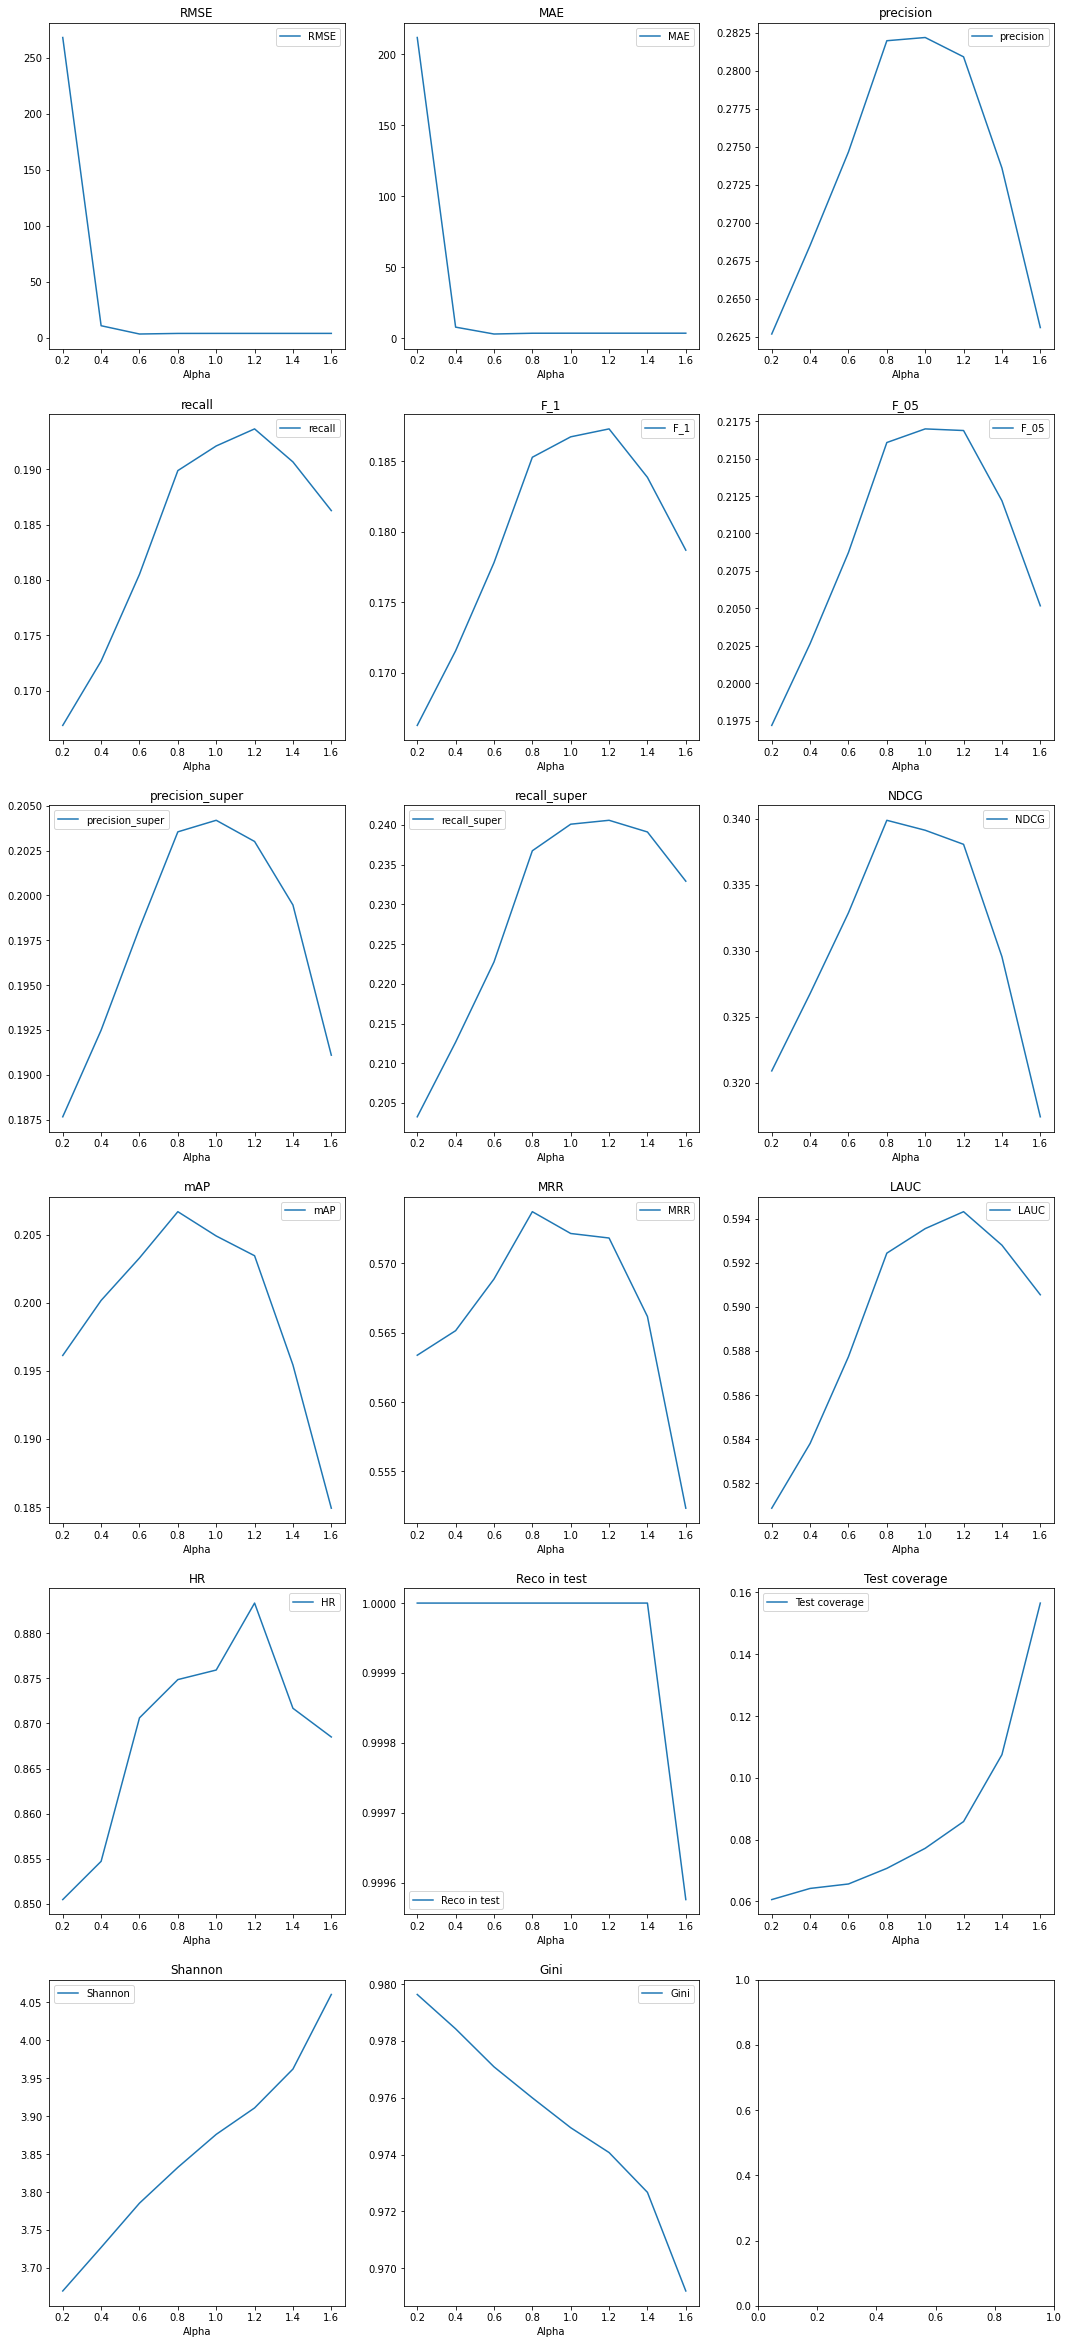

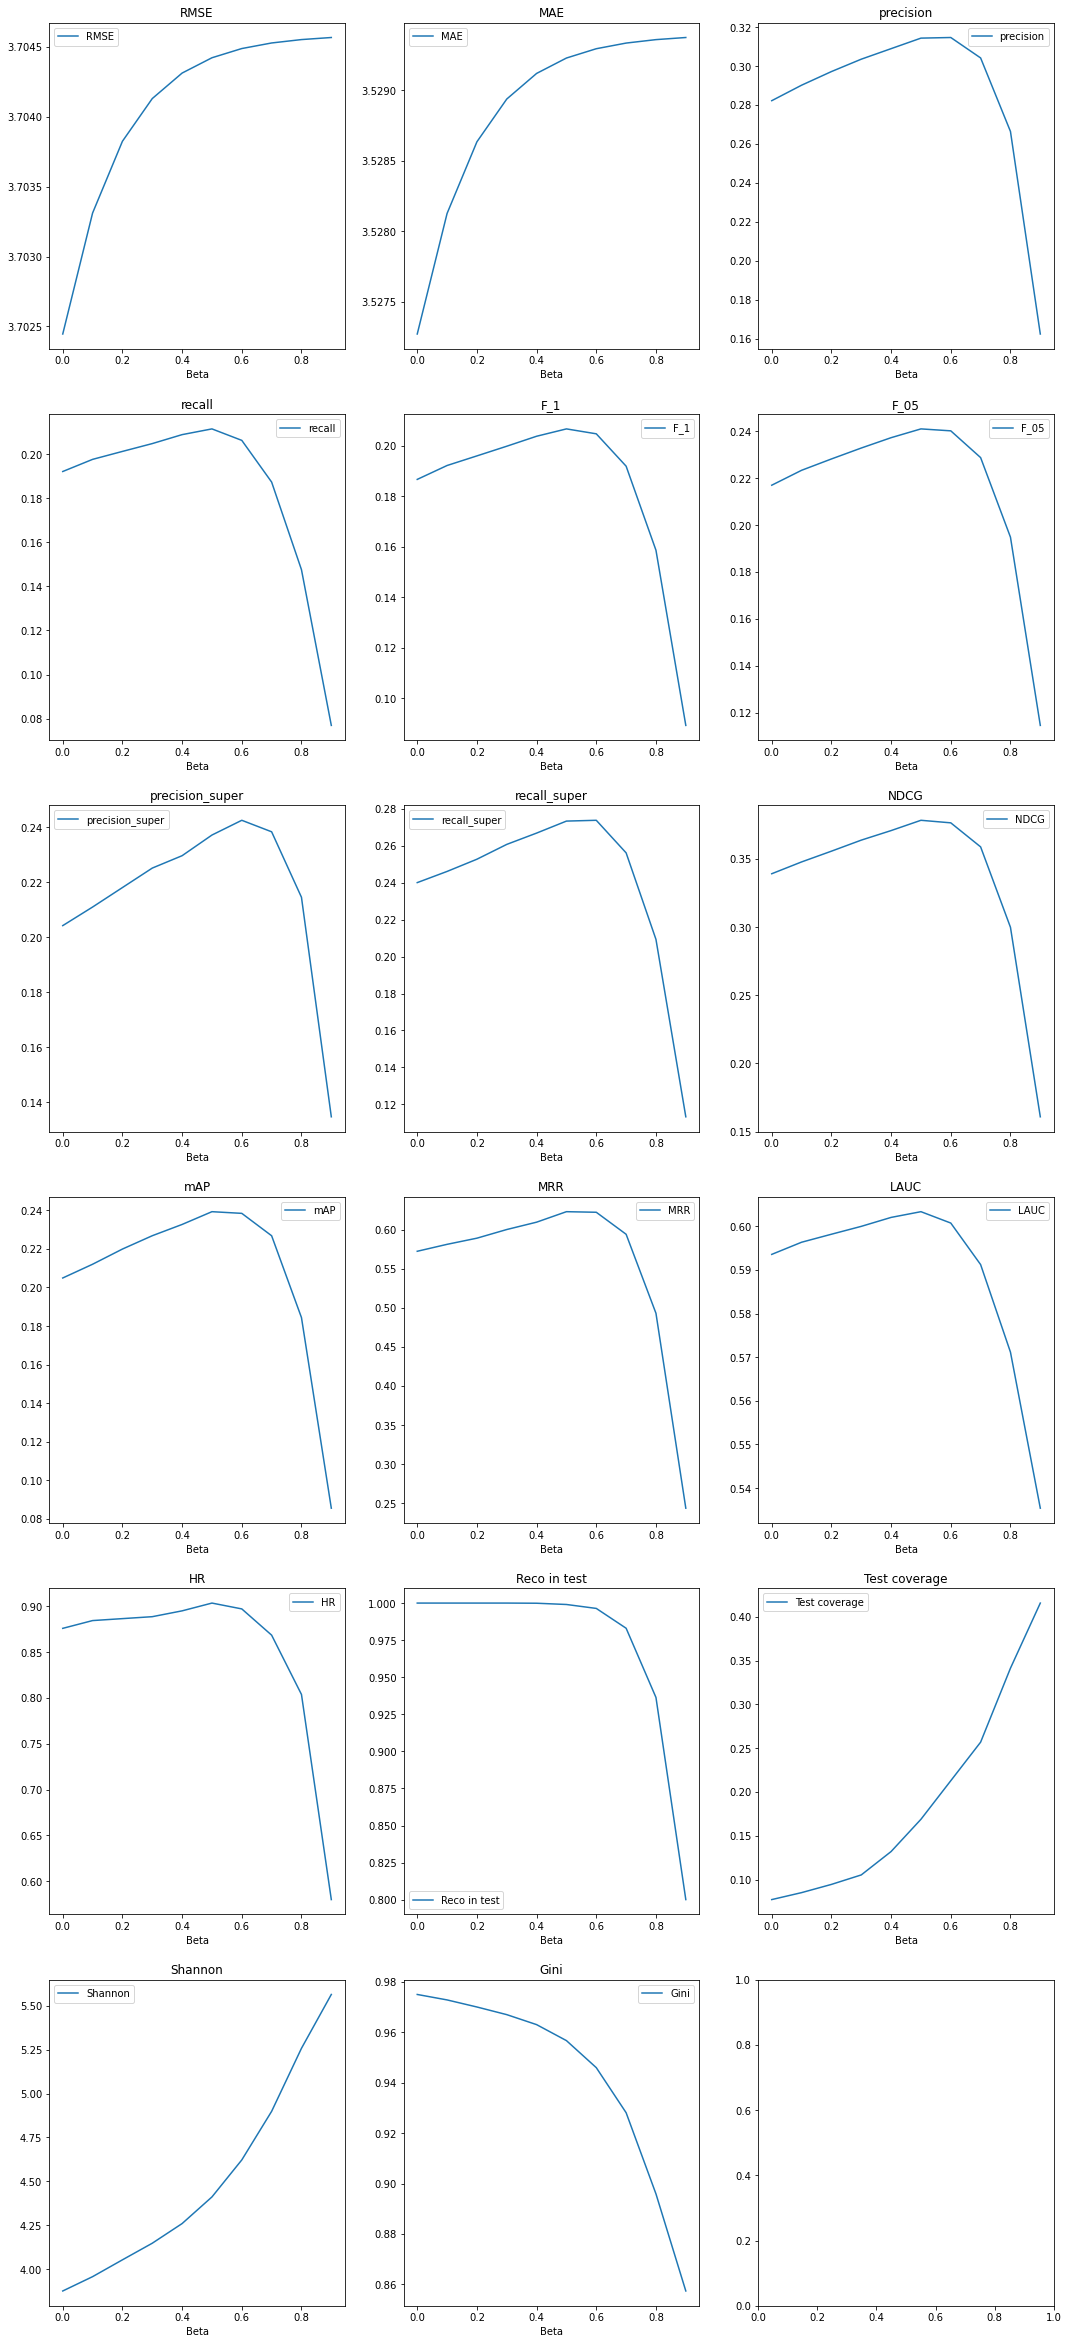

In [10]:
train=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

user=random.choice(list(set(train['user'])))

train_content=pd.merge(train, items, left_on='item', right_on='id')
display(train_content[train_content['user']==user][['user', 'rating', 'title', 'genres']]\
        .sort_values(by='rating', ascending=False)[:15])

reco = np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

# Let's ignore scores - they are not used in evaluation: 
reco_users=reco[:,:1]
reco_items=reco[:,1::2]
# Let's put them into one array
reco=np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended=[]
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb+1, entry))
recommended=pd.DataFrame(recommended, columns=['user','rec_nb', 'item'])

recommended_content=pd.merge(recommended, items, left_on='item', right_on='id')
recommended_content[recommended_content['user']==user][['user', 'rec_nb', 'title', 'genres']].sort_values(by='rec_nb')

# project task 6: generate recommendations of RP3Beta for hiperparameters found to optimize recall

In [11]:
# use better values than (1,0) for alpha and beta
# if you want you can also modify the model to consider different weights (we took as weights user ratings, maybe take ones or squares of ratings instead)
# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'model=RP3Beta()
model.fit(train_ui, alpha=1.4, beta=0.3)
top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index=False, header=False)
import evaluation_measures as ev
estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='	', header=None),            estimations_df=estimations_df,            reco=reco,            super_reactions=[4,5])

943it [00:00, 9215.29it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.704589  3.529397   0.286744  0.196524  0.191117  0.221375   

   precision_super  recall_super      NDCG       mAP       MRR     LAUC  \
0         0.213948      0.251263  0.344598  0.207836  0.587953  0.59577   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.885472      0.998197       0.193362  4.291821  0.960775

# project task 7 (optional): implement graph-based model of your choice 

In [12]:
# for example change length of paths in RP3beta
# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'